<a href="https://colab.research.google.com/github/butoialexandra/Determining-country-specific-engagement-in-climate-change-policies/blob/main/3_Topic_Modeling_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code adapted from [here](https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know?utm_source=datacamp&utm_medium=post&utm_campaign=blog-pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know)


Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Check you're in the right place

In [2]:
!pwd

/content


In [3]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


Download these libraries if haven't done already

In [ ]:
!python -m spacy download en
!pip install pyLDAvis==3.2.1

Imports

In [5]:
import re
import numpy as np
import pandas as pd
import glob
from pprint import pprint
from tqdm import tqdm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Load data

In [6]:
df = pd.read_csv("./data.csv") 

In [7]:
df.head(5)

,Document,NDC
0,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...,Cabo Verde is committed to implement the Susta...
1,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...,The means of implementation of NDCs of Sri Lan...
2,../txts/RWA_Rwanda_First_NDC_English_Paragraph...,This updated NDC updates and strengthens the f...
3,../txts/NER_Niger_First_NDC_Translation_Englis...,to use climate financing and benefit from the ...
4,../txts/GMB_Gambia_First_NDC_English_Paragraph...,Gambia Watershed by a) Improving disaster prep...


Some processing

In [17]:
df['NDC_processed'] = df['NDC'].apply(lambda x: re.sub('[(),\.!?0-9]', '', x))
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: x.lower())
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: x.strip())
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: re.sub(' +', ' ', x))
df = df[df['NDC_processed'].apply(lambda x: len(x) > 100)]

<input>:1: DeprecationWarning: invalid escape sequence \.
<input>:1: DeprecationWarning: invalid escape sequence \.
<input>:1: DeprecationWarning: invalid escape sequence \.
<input>:1: DeprecationWarning: invalid escape sequence \.
<input>:1: DeprecationWarning: invalid escape sequence \.
<ipython-input-17-9ef35965a6fd>:1: DeprecationWarning: invalid escape sequence \.
  df['NDC_processed'] = df['NDC'].apply(lambda x: re.sub('[(),\.!?0-9]', '', x))


In [18]:
df.head()

,Document,NDC,NDC_processed
0,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...,Cabo Verde is committed to implement the Susta...,cabo verde is committed to implement the susta...
2,../txts/RWA_Rwanda_First_NDC_English_Paragraph...,This updated NDC updates and strengthens the f...,this updated ndc updates and strengthens the f...
4,../txts/GMB_Gambia_First_NDC_English_Paragraph...,Gambia Watershed by a) Improving disaster prep...,gambia watershed by a improving disaster prepa...
7,../txts/JOR_Jordan_First_NDC_English_Paragraph...,The estimated cost to reach the 14 target is t...,the estimated cost to reach the target is tota...
8,../txts/FSM_Micronesia_First_NDC_English_Parag...,"Moreover, national efforts to implement INDC i...",moreover national efforts to implement indc in...


Process data for LDA

In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [22]:
ndcs = df.NDC_processed.values.tolist()
words = list(sent_to_words(ndcs))

bigram = gensim.models.Phrases(words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
data_words_nostops = remove_stopwords(words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

Make corpus

In [24]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

Train LDA model with 10 topics

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [26]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.055*"management" + 0.044*"use" + 0.044*"forest" + 0.043*"system" + '
  '0.040*"land" + 0.030*"improve" + 0.027*"promote" + 0.024*"community" + '
  '0.021*"forestry" + 0.021*"agriculture"'),
 (1,
  '0.100*"increase" + 0.026*"year" + 0.026*"result" + 0.025*"temperature" + '
  '0.020*"could" + 0.018*"percent" + 0.014*"average" + 0.014*"rainfall" + '
  '0.014*"show" + 0.013*"large"'),
 (2,
  '0.038*"mitigation" + 0.037*"contribution" + 0.033*"sector" + '
  '0.032*"include" + 0.029*"estimate" + 0.028*"report" + 0.028*"cost" + '
  '0.027*"use" + 0.022*"potential" + 0.022*"account"'),
 (3,
  '0.090*"emission" + 0.031*"country" + 0.029*"reduction" + 0.028*"target" + '
  '0.024*"reduce" + 0.021*"growth" + 0.017*"ghg" + 0.016*"global" + '
  '0.015*"low" + 0.015*"carbon"'),
 (4,
  '0.125*"energy" + 0.038*"sector" + 0.028*"renewable" + 0.027*"waste" + '
  '0.026*"electricity" + 0.024*"efficiency" + 0.023*"transport" + '
  '0.019*"power" + 0.019*"generation" + 0.016*"use"'),
 (5,
  '0.038

Check perplexity and coherence score

In [27]:
print('Perplexity: {}'.format(lda_model.log_perplexity(corpus)))

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: {}'.format(coherence_lda))

Datele de ieșire de afișat au fost trunchiate la ultimele 5000 linii.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  

Perplexity: -7.314880214227677
Coherence Score: 0.5160931467397184


Visualize topics

In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.280103  0.014319       1        1  28.026256
5     -0.218883 -0.006275       2        1  14.431648
3     -0.109043 -0.277968       3        1  13.642590
9      0.027038 -0.059072       4        1   8.035317
0      0.050027  0.203982       5        1   7.729709
2     -0.066156  0.165140       6        1   7.186578
4      0.061283  0.190842       7        1   6.940443
1      0.139168 -0.133145       8        1   5.811738
6      0.191131 -0.109994       9        1   5.567174
8      0.205538  0.012172      10        1   2.628547, topic_info=              Term         Freq        Total Category  logprob  loglift
90         climate  6149.000000  6149.000000  Default  30.0000  30.0000
152       emission  3680.000000  3680.000000  Default  29.0000  29.0000
1           energy  2565.000000  2565.000000  Default  28.0000  28.0000
89          change  4707.000000  4707.000000  Default  27.0000  27.0000
110       increase  1730.000000  1730.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
2068       organic    41.638603    42.550437  Topic10  -5.2317   3.6171
283    subsistence    41.350793    42.262911  Topic10  -5.2386   3.6169
880          staff    39.015339    39.927322  Topic10  -5.2968   3.6156
161   agricultural   405.974052   504.278164  Topic10  -2.9544   3.4219
246     production   463.372422   590.830297  Topic10  -2.8222   3.3957

[432 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
272       2  0.784096      access
272       4  0.214454      access
1293      6  0.997029  accordance
61        3  0.068781     account
61        6  0.930560     account
...     ...       ...         ...
180       3  0.996967       would
148       3  0.203252        year
148       6  0.314505        year
148       8  0.481385        year
1049      4  0.993019        zone

[481 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 4, 10, 1, 3, 5, 2, 7, 9])

Train LDA using Mallet

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

mallet_path = 'mallet-2.0.8/bin/mallet'

Train LDA with Mallet

In [30]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)
pprint(ldamallet.show_topics(formatted=False))

coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: {}'.format(coherence_ldamallet))

[(0,
  [('support', 0.05164219337447684),
   ('project', 0.04312974391714549),
   ('capacity', 0.040079449528268425),
   ('measure', 0.032524650634886854),
   ('implementation', 0.030432006809959566),
   ('implement', 0.028658579839682202),
   ('technology', 0.02582109668723842),
   ('investment', 0.02450876072923317),
   ('building', 0.02252252252252252),
   ('international', 0.022487053983116977)]),
 (1,
  [('development', 0.08834507042253521),
   ('plan', 0.06862676056338028),
   ('national', 0.0644718309859155),
   ('policy', 0.0571830985915493),
   ('action', 0.05514084507042254),
   ('strategy', 0.044507042253521124),
   ('sustainable', 0.022887323943661973),
   ('develop', 0.021514084507042255),
   ('government', 0.019647887323943663),
   ('environment', 0.01630281690140845)]),
 (2,
  [('water', 0.06519803321847535),
   ('management', 0.04835649850942739),
   ('resource', 0.04758217507452863),
   ('system', 0.04123272290835882),
   ('improve', 0.031166518254674976),
   ('promote

Train Mallet for different number of topics and choose the model with best coherence score

In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=3)

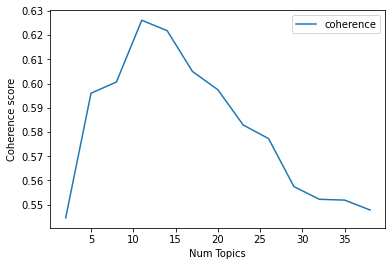

In [33]:
limit, start, step = 40, 2, 3
x = range(start, limit, step)
plt.plot(x, coherence_values, label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')
plt.show()

In [34]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5445
Num Topics = 5  has Coherence Value of 0.596
Num Topics = 8  has Coherence Value of 0.6006
Num Topics = 11  has Coherence Value of 0.6261
Num Topics = 14  has Coherence Value of 0.6218
Num Topics = 17  has Coherence Value of 0.605
Num Topics = 20  has Coherence Value of 0.5974
Num Topics = 23  has Coherence Value of 0.5829
Num Topics = 26  has Coherence Value of 0.5773
Num Topics = 29  has Coherence Value of 0.5575
Num Topics = 32  has Coherence Value of 0.5522
Num Topics = 35  has Coherence Value of 0.5519
Num Topics = 38  has Coherence Value of 0.5478


Print top words for the best model

In [35]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.054*"country" + 0.032*"global" + 0.027*"effort" + 0.026*"contribution" + '
  '0.018*"commitment" + 0.018*"develop" + 0.016*"contribute" + '
  '0.015*"paris_agreement" + 0.014*"unfccc" + 0.014*"make"'),
 (1,
  '0.080*"mitigation" + 0.062*"measure" + 0.056*"action" + 0.048*"include" + '
  '0.047*"implementation" + 0.040*"adaptation" + 0.029*"target" + '
  '0.025*"implement" + 0.025*"contribution" + 0.022*"set"'),
 (2,
  '0.031*"level" + 0.027*"process" + 0.026*"report" + 0.021*"system" + '
  '0.021*"base" + 0.020*"approach" + 0.019*"information" + 0.019*"national" + '
  '0.019*"assessment" + 0.019*"datum"'),
 (3,
  '0.110*"energy" + 0.027*"source" + 0.026*"renewable" + 0.024*"reduce" + '
  '0.023*"transport" + 0.023*"electricity" + 0.022*"waste" + '
  '0.020*"efficiency" + 0.017*"generation" + 0.015*"power"'),
 (4,
  '0.144*"sector" + 0.057*"project" + 0.040*"include" + 0.030*"economic" + '
  '0.026*"cost" + 0.019*"activity" + 0.017*"future" + 0.016*"potential" + '
  '0.015*"ad

Converd Mallet model to gensim in order to be able to visualize topics with pyLDAvis

In [37]:
def convertldaGenToldaMallet(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(optimal_model)

In [38]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6     -0.240871 -0.100633       1        1  9.921210
8      0.020846  0.119212       2        1  9.352326
0      0.045522 -0.193453       3        1  9.193592
7      0.248712  0.086467       4        1  9.108756
10    -0.141386  0.270266       5        1  9.087318
5     -0.187013 -0.183297       6        1  9.046905
9      0.143955  0.145769       7        1  9.026810
3     -0.197158  0.196209       8        1  8.937964
4     -0.078007 -0.179326       9        1  8.876095
2      0.170617 -0.064444      10        1  8.755805
1      0.214782 -0.096769      11        1  8.693220, topic_info=            Term         Freq        Total Category  logprob  loglift
90       climate  6631.000000  6631.000000  Default  30.0000  30.0000
89        change  5124.000000  5124.000000  Default  29.0000  29.0000
152     emission  4176.000000  4176.000000  Default  28.0000  28.0000
36        sector  3793.000000  3793.000000  Default  27.0000  27.0000
1         energy  2917.000000  2917.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
467          ndc   183.228408   436.558044  Topic11  -4.9461   1.5744
290         goal   187.670310   552.395415  Topic11  -4.9221   1.3630
31       provide   200.996015   923.583632  Topic11  -4.8535   0.9177
482       relate   176.565556   466.018990  Topic11  -4.9831   1.4721
850  information   182.117933   686.639407  Topic11  -4.9522   1.1155

[783 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
272       7  0.999322      access
80        1  0.234179      accord
80        6  0.761082      accord
80       11  0.006163      accord
1293      3  0.998272  accordance
...     ...       ...         ...
1182      2  1.000484       woman
530       3  0.019088        work
530      10  0.979839        work
148       1  0.199634        year
148       6  0.800386        year

[972 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 1, 8, 11, 6, 10, 4, 5, 3, 2])

Compute dominant topic for each document

In [39]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = df.NDC_processed
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [44]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df.NDC)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1342,"country, global, effort, contribution, commitm...",cabo verde is committed to implement the susta...
1,1,1.0,0.2097,"mitigation, measure, action, include, implemen...",NaN
2,2,8.0,0.1425,"climate, change, adaptation, impact, resilienc...",this updated ndc updates and strengthens the f...
3,3,5.0,0.1700,"emission, reduction, year, reduce, growth, ghg...",NaN
4,4,0.0,0.1223,"country, global, effort, contribution, commitm...",gambia watershed by a improving disaster prepa...
5,5,10.0,0.1255,"water, management, area, land, forest, resourc...",NaN
6,6,6.0,0.3946,"increase, population, high, temperature, resul...",NaN
7,7,5.0,0.1761,"emission, reduction, year, reduce, growth, ghg...",the estimated cost to reach the target is tota...
8,8,0.0,0.0909,"country, global, effort, contribution, commitm...",moreover national efforts to implement indc in...
9,9,5.0,0.1664,"emission, reduction, year, reduce, growth, ghg...",NaN


In [42]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
   
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4410,"country, global, effort, contribution, commitm...",decrease and a decline in the population and s...
1,1.0,0.3720,"mitigation, measure, action, include, implemen...",in order to fully implement the mitigation and...
2,2.0,0.4654,"level, process, report, system, base, approach...",coastal communities depending on fisheries and...
3,3.0,0.4334,"energy, source, renewable, reduce, transport, ...",NaN
4,4.0,0.3825,"sector, project, include, economic, cost, acti...",NaN


In [43]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"country, global, effort, contribution, commitm...",920.0,0.0850
1.0,1.0,"mitigation, measure, action, include, implemen...",696.0,0.0643
2.0,8.0,"climate, change, adaptation, impact, resilienc...",1041.0,0.0962
3.0,5.0,"emission, reduction, year, reduce, growth, ghg...",1370.0,0.1266
4.0,0.0,"country, global, effort, contribution, commitm...",471.0,0.0435
...,...,...,...,...
22366.0,NaN,NaN,NaN,NaN
22368.0,NaN,NaN,NaN,NaN
22373.0,NaN,NaN,NaN,NaN
22374.0,NaN,NaN,NaN,NaN
